# Join attributes from various layers to shoreline segments

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import descartes
# from matplotlib import pyplot
# import plotly.express as px

In [2]:
# Source/working directories, geopackage, layers and shapefiles
work_dir = '/Users/arbailey/natcap/idb/data/work/sargassum/shore_segments'
gpkg = 'shoreline_segments.gpkg'
shore_gpkg = os.path.join(work_dir, gpkg)
print(shore_gpkg)

/Users/arbailey/natcap/idb/data/work/sargassum/shore_segments/shoreline_segments.gpkg


# Load data

In [3]:
# Shoreline Segments and points
# Import shoreline points and shoreline segments
shore_segments_gdf = gpd.read_file(shore_gpkg, layer='shoreQR_segments')
shore_points_gdf = gpd.read_file(shore_gpkg, layer='shoreQR_50m_pts')
print(shore_segments_gdf.dtypes)
print(shore_points_gdf.crs)
shore_points_gdf

type_geomorph      object
length_km         float64
seg_id              int64
shore_desc         object
desc_abbrev        object
geometry         geometry
dtype: object
{'init': 'epsg:32616'}


,shore_desc,desc_abbrev,distance,shore_ptid,type_geomorph,seg_id,nearest_x,nearest_y,geometry
0,Isla Mujeres,imu,10.0,imu_000010,sand,190,2.351487e+06,526079.020764,POINT (526079.021 2351487.282)
1,Isla Mujeres,imu,60.0,imu_000060,sand,190,2.351521e+06,526069.071721,POINT (526069.072 2351520.957)
2,Isla Mujeres,imu,110.0,imu_000110,sand,190,2.351481e+06,526050.024372,POINT (526050.024 2351480.878)
3,Isla Mujeres,imu,160.0,imu_000160,sand,190,2.351494e+06,526015.595971,POINT (526015.596 2351494.100)
4,Isla Mujeres,imu,210.0,imu_000210,sand,190,2.351456e+06,526010.366221,POINT (526010.366 2351455.699)
...,...,...,...,...,...,...,...,...,...
26102,Cozumel,coz,133360.0,coz_133360,cliff or rocky,187,2.271962e+06,514841.054102,POINT (514841.054 2271962.273)
26103,Cozumel,coz,133410.0,coz_133410,cliff or rocky,187,2.272006e+06,514817.592981,POINT (514817.593 2272006.427)
26104,Cozumel,coz,133460.0,coz_133460,cliff or rocky,187,2.272051e+06,514794.066007,POINT (514794.066 2272050.519)
26105,Cozumel,coz,133510.0,coz_133510,cliff or rocky,187,2.272076e+06,514751.274532,POINT (514751.275 2272076.382)


# Find amenities/services within specified distance of Segment Points

In [4]:
buffer_distance = 1000  # distance in meters

## Borja Hotel data

In [5]:
# Load QR hotels from Borja  (source in WGS-84)
QRhotels_gdf = gpd.read_file('/Users/arbailey/natcap/idb/data/source/borja_QR/QR_hotels/shp/HotelesQR.shp').to_crs({'init': 'epsg:32616'})
print(QRhotels_gdf.crs)
print(QRhotels_gdf.dtypes)
# Add attribute with more specific name
QRhotels_gdf['QRhotel_id'] = QRhotels_gdf['ID'] + 1  # so we don't have an ID of zero
QRhotels_gdf

{'init': 'epsg:32616', 'no_defs': True}
ID               int64
Name            object
Latitude       float64
Longitude      float64
StarRating     float64
Aloja_noSt      object
LRate_Expe     float64
H_Rate_Exp     float64
M_Rate_Exp     float64
Cuartos          int64
LRateTripa     float64
HRateTripa     float64
MinEmplead       int64
MaxEmplead      object
MedEmplead       int64
Municipio_      object
geometry      geometry
dtype: object


,ID,Name,Latitude,Longitude,StarRating,Aloja_noSt,LRate_Expe,H_Rate_Exp,M_Rate_Exp,Cuartos,LRateTripa,HRateTripa,MinEmplead,MaxEmplead,MedEmplead,Municipio_,geometry,QRhotel_id
0,0,Royal Caribbean Resort,17.89830,-87.97649,3.0,None,140.00,165.00,152.50,42,90.0,150.0,0,None,29,SanPedro_Belize,POINT (396563.025 1979204.817),1
1,1,Victoria House,17.90000,-87.97701,4.0,None,335.00,336.00,335.50,42,0.0,223.0,0,None,40,SanPedro_Belize,POINT (396508.924 1979393.207),2
2,2,Mata Rocks Resort,17.90394,-87.97612,3.0,None,155.42,156.42,155.92,17,124.0,196.0,0,None,12,SanPedro_Belize,POINT (396605.489 1979828.667),3
3,3,Banana Beach Resort,17.90425,-87.97600,3.0,None,95.00,145.00,120.00,64,103.0,183.0,0,None,44,SanPedro_Belize,POINT (396618.381 1979862.901),4
4,4,Grand Colony Island Villas,17.90662,-87.97503,3.5,None,534.01,1066.67,800.34,15,283.0,659.0,0,None,11,SanPedro_Belize,POINT (396722.507 1980124.600),5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,954,Villas HM Paraiso del Mar,21.52761,-87.37225,4.0,None,214.00,330.44,272.22,58,120.0,324.0,0,None,55,LazaroCardenas,POINT (461449.888 2380587.457),955
955,955,Villas Delfines,21.52843,-87.37093,3.0,None,120.00,201.78,160.89,20,84.0,194.0,0,None,14,LazaroCardenas,POINT (461586.804 2380677.890),956
956,956,Villas Tiburon,21.53097,-87.36763,3.0,None,100.72,129.12,114.92,15,0.0,0.0,0,None,11,LazaroCardenas,POINT (461929.214 2380958.213),957
957,957,Villas Flamingos,21.53246,-87.36616,3.5,None,246.51,280.08,263.30,29,113.0,257.0,0,None,20,LazaroCardenas,POINT (462081.832 2381122.770),958


In [6]:
# Buffer hotel points for proximity analysis with segments
# Looking to associate the closest hotels to each beach segment
# One hotel can be associated with multiple beach segments
QRhotels_buffer_gdf = QRhotels_gdf
QRhotels_buffer_gdf['geometry'] = QRhotels_gdf['geometry'].buffer(buffer_distance)
QRhotels_buffer_gdf

,ID,Name,Latitude,Longitude,StarRating,Aloja_noSt,LRate_Expe,H_Rate_Exp,M_Rate_Exp,Cuartos,LRateTripa,HRateTripa,MinEmplead,MaxEmplead,MedEmplead,Municipio_,geometry,QRhotel_id
0,0,Royal Caribbean Resort,17.89830,-87.97649,3.0,None,140.00,165.00,152.50,42,90.0,150.0,0,None,29,SanPedro_Belize,"POLYGON ((397563.025 1979204.817, 397558.209 1...",1
1,1,Victoria House,17.90000,-87.97701,4.0,None,335.00,336.00,335.50,42,0.0,223.0,0,None,40,SanPedro_Belize,"POLYGON ((397508.924 1979393.207, 397504.109 1...",2
2,2,Mata Rocks Resort,17.90394,-87.97612,3.0,None,155.42,156.42,155.92,17,124.0,196.0,0,None,12,SanPedro_Belize,"POLYGON ((397605.489 1979828.667, 397600.674 1...",3
3,3,Banana Beach Resort,17.90425,-87.97600,3.0,None,95.00,145.00,120.00,64,103.0,183.0,0,None,44,SanPedro_Belize,"POLYGON ((397618.381 1979862.901, 397613.565 1...",4
4,4,Grand Colony Island Villas,17.90662,-87.97503,3.5,None,534.01,1066.67,800.34,15,283.0,659.0,0,None,11,SanPedro_Belize,"POLYGON ((397722.507 1980124.600, 397717.692 1...",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,954,Villas HM Paraiso del Mar,21.52761,-87.37225,4.0,None,214.00,330.44,272.22,58,120.0,324.0,0,None,55,LazaroCardenas,"POLYGON ((462449.888 2380587.457, 462445.073 2...",955
955,955,Villas Delfines,21.52843,-87.37093,3.0,None,120.00,201.78,160.89,20,84.0,194.0,0,None,14,LazaroCardenas,"POLYGON ((462586.804 2380677.890, 462581.988 2...",956
956,956,Villas Tiburon,21.53097,-87.36763,3.0,None,100.72,129.12,114.92,15,0.0,0.0,0,None,11,LazaroCardenas,"POLYGON ((462929.214 2380958.213, 462924.399 2...",957
957,957,Villas Flamingos,21.53246,-87.36616,3.5,None,246.51,280.08,263.30,29,113.0,257.0,0,None,20,LazaroCardenas,"POLYGON ((463081.832 2381122.770, 463077.017 2...",958


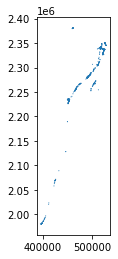

In [7]:
QRhotels_buffer_gdf.plot()

In [8]:
# Spatially Join the hotel buffers to Shore segment points
QRhotels_shorepts_join = gpd.sjoin(shore_points_gdf, QRhotels_buffer_gdf, op='intersects')
QRhotels_shorepts_join

/Users/arbailey/miniconda3/envs/geoenv/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:32616'} != {'init': 'epsg:32616', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


,shore_desc,desc_abbrev,distance,shore_ptid,type_geomorph,seg_id,nearest_x,nearest_y,geometry,index_right,...,H_Rate_Exp,M_Rate_Exp,Cuartos,LRateTripa,HRateTripa,MinEmplead,MaxEmplead,MedEmplead,Municipio_,QRhotel_id
0,Isla Mujeres,imu,10.0,imu_000010,sand,190,2.351487e+06,526079.020764,POINT (526079.021 2351487.282),902,...,0.0,0.0,13,40.0,55.0,1,5,3,IslaMujeres,903
2,Isla Mujeres,imu,110.0,imu_000110,sand,190,2.351481e+06,526050.024372,POINT (526050.024 2351480.878),902,...,0.0,0.0,13,40.0,55.0,1,5,3,IslaMujeres,903
3,Isla Mujeres,imu,160.0,imu_000160,sand,190,2.351494e+06,526015.595971,POINT (526015.596 2351494.100),902,...,0.0,0.0,13,40.0,55.0,1,5,3,IslaMujeres,903
4,Isla Mujeres,imu,210.0,imu_000210,sand,190,2.351456e+06,526010.366221,POINT (526010.366 2351455.699),902,...,0.0,0.0,13,40.0,55.0,1,5,3,IslaMujeres,903
5,Isla Mujeres,imu,260.0,imu_000260,sand,190,2.351411e+06,526016.632782,POINT (526016.633 2351411.256),902,...,0.0,0.0,13,40.0,55.0,1,5,3,IslaMujeres,903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25910,Cozumel,coz,123760.0,coz_123760,sand,107,2.272914e+06,508708.742720,POINT (508708.743 2272913.927),296,...,90.3,86.0,143,0.0,0.0,0,None,134,Cozumel,297
25911,Cozumel,coz,123810.0,coz_123810,sand,107,2.272922e+06,508758.073717,POINT (508758.074 2272921.986),296,...,90.3,86.0,143,0.0,0.0,0,None,134,Cozumel,297
25912,Cozumel,coz,123860.0,coz_123860,sand,107,2.272929e+06,508807.591370,POINT (508807.591 2272928.915),296,...,90.3,86.0,143,0.0,0.0,0,None,134,Cozumel,297
25913,Cozumel,coz,123910.0,coz_123910,sand,107,2.272933e+06,508857.330505,POINT (508857.331 2272933.035),296,...,90.3,86.0,143,0.0,0.0,0,None,134,Cozumel,297


In [9]:
# df = df.groupby('domain')['ID'].nunique()
hotel_count_seg_df = QRhotels_shorepts_join.groupby(['seg_id'])['QRhotel_id'].nunique().reset_index()
hotel_count_seg_df.rename(columns={'QRhotel_id': 'hotel_cnt'}, inplace=True)
hotel_count_seg_df

,seg_id,hotel_cnt
0,1,8
1,4,1
2,7,3
3,12,8
4,18,4
...,...,...
98,190,49
99,191,23
100,192,16
101,195,32


In [10]:
hotel_rating_seg_df = QRhotels_shorepts_join.groupby(['seg_id','StarRating'])['QRhotel_id'].nunique().reset_index()
hotel_rating_seg_df.rename(columns={'QRhotel_id': 'htlstar_cnt'}, inplace=True)
hotel_rating_seg_df

,seg_id,StarRating,htlstar_cnt
0,1,0.0,1
1,1,2.5,1
2,1,3.0,3
3,1,4.0,3
4,4,0.0,1
...,...,...,...
339,197,2.5,1
340,197,3.0,2
341,197,3.5,1
342,197,4.0,4


## DENUE

In [67]:
# Load INEGI DENUE data  (source in epsg:6365)
denue_gdf = gpd.read_file('/Users/arbailey/natcap/idb/data/source/inegi/denue/denue_23/conjunto_de_datos/denue.shp').to_crs({'init': 'epsg:32616'})
print(denue_gdf.crs)
print(denue_gdf.dtypes)
# relevant columns are: 
denue_cols = ['d_llave', 'nom_est', 'cve_scian', 'desc_scian','sector','geometry']
# d_llave -- unique id
# nom_est -- establishment name
# cve_scian - NAICS code
# desc_scian -- NAICS description
# sector
denue_gdf = denue_gdf[denue_cols]
denue_gdf

{'init': 'epsg:32616'}
d_llave          int64
cve_ent         object
nom_ent         object
cve_mun         object
nom_mun         object
cve_loc         object
nom_loc         object
cve_ageb        object
manzana         object
nom_est         object
raz_soc         object
tipovial        object
nomvial         object
tiporef1        object
nomref1         object
tiporef2        object
nomref2         object
tiporef3        object
nomref3         object
numextnum       object
numextalf       object
numintnum       object
numintalf       object
tipoasen        object
nomasen         object
edif_nom        object
edif_piso       object
cp              object
tel_1           object
cve_scian       object
desc_scian      object
sector          object
tipo_cori       object
cor_indust      object
local           object
dir_elec_1      object
sitio_web       object
facebook        object
twitter         object
tipo_est        object
estr_poc        object
fecha_alta      object
coord_x    

,d_llave,nom_est,cve_scian,desc_scian,sector,geometry
0,6384383,HOTEL COLONIAL SAN CARLOS,721112,Hoteles sin otros servicios integrados,72,POINT (517944.023 2340691.007)
1,6312675,PANALPINA SERVICIOS,561330,Suministro de personal permanente,56,POINT (526350.130 2337054.328)
2,3646950,CONSULTORIO DENTAL,621211,Consultorios dentales del sector privado,62,POINT (491879.968 2280684.123)
3,9108120,MAFER REGALOS,465912,Comercio al por menor de regalos,46,POINT (516582.969 2340711.935)
4,3627296,BORDADOS Y ESTAMPADOS BYE,323119,Impresión de formas continuas y otros impresos,31,POINT (515983.496 2341706.323)
...,...,...,...,...,...,...
65606,3614529,CEMENTERIO MUNICIPAL,812322,Administración de cementerios pertenecientes a...,81,POINT (320331.248 2185142.738)
65607,8892489,SERVICIOS FUNERARIOS CAMPESTRE RECINTO EXEQUIAL,812310,Servicios funerarios,81,POINT (361187.852 2046695.491)
65608,8705529,FUNERARIA SAN PEDRO DE GUERRERO,812310,Servicios funerarios,81,POINT (515605.670 2340967.936)
65609,3614945,PANTEON MUNICIPAL EL RECUERDO,812322,Administración de cementerios pertenecientes a...,81,POINT (332522.061 2166690.435)


In [68]:
# Denue business type subsets (using NACIS code)
# Lodging -- "cve_scian" LIKE '721%'
denue_lodging_gdf = denue_gdf.copy()
denue_lodging_gdf = denue_lodging_gdf[(denue_lodging_gdf['cve_scian'].str.startswith('721'))]
denue_lodging_gdf['dnu_type'] = 'lodging'
denue_lodging_gdf

,d_llave,nom_est,cve_scian,desc_scian,sector,geometry,dnu_type,dnu_lodg
0,6384383,HOTEL COLONIAL SAN CARLOS,721112,Hoteles sin otros servicios integrados,72,POINT (517944.023 2340691.007),lodging,1
218,6384240,HOSPEDAJE MARIA LETICIA,721311,Pensiones y casas de huéspedes,72,POINT (526047.547 2350665.510),lodging,1
411,3642060,VILLAS DEJA BLUE,721312,Departamentos y casas amueblados con servicios...,72,POINT (504326.389 2266807.488),lodging,1
442,6383956,HOTEL PEPITA,721112,Hoteles sin otros servicios integrados,72,POINT (505397.687 2267714.779),lodging,1
592,6484081,POSADA LAMAR,721311,Pensiones y casas de huéspedes,72,POINT (452617.398 2229737.121),lodging,1
...,...,...,...,...,...,...,...,...
65143,3632435,CASA MEXICANA,721311,Pensiones y casas de huéspedes,72,POINT (519964.276 2342569.118),lodging,1
65144,8719868,HOTEL SUITS VERSALLES,721312,Departamentos y casas amueblados con servicios...,72,POINT (517682.435 2340444.655),lodging,1
65145,8839736,HOSTEL CAN,721311,Pensiones y casas de huéspedes,72,POINT (518543.561 2340312.234),lodging,1
65147,6871727,CAMPAMENTO RECREATIVO PLAYA AVENTURAS,721210,Campamentos y albergues recreativos,72,POINT (465314.287 2251802.299),lodging,1


In [69]:
# Food / Drink -- "cve_scian" LIKE '722%'
denue_foodbev_gdf = denue_gdf.copy()
denue_foodbev_gdf = denue_foodbev_gdf[(denue_gdf['cve_scian'].str.startswith('722'))]
denue_foodbev_gdf['dnu_type'] = 'food_bev'
denue_foodbev_gdf

,d_llave,nom_est,cve_scian,desc_scian,sector,geometry,dnu_type,dnu_fdbev
287,8889767,OLLAS Y SARTENES,722513,Restaurantes con servicio de preparación de an...,72,POINT (517730.736 2340097.703),food_bev,1
347,8367810,TAQUERIA NEZA,722514,Restaurantes con servicio de preparación de ta...,72,POINT (515812.937 2338176.540),food_bev,1
444,7861301,TEA CHIA,722513,Restaurantes con servicio de preparación de an...,72,POINT (505553.694 2268195.518),food_bev,1
447,7849790,TAQUERIA CAMILA,722514,Restaurantes con servicio de preparación de ta...,72,POINT (353176.978 2066313.997),food_bev,1
449,3642377,ANTOJITOS DOÑA DALI,722513,Restaurantes con servicio de preparación de an...,72,POINT (504839.782 2267425.673),food_bev,1
...,...,...,...,...,...,...,...,...
65267,8915849,RESTAURANT HUNAB KU,722511,Restaurantes con servicio de preparación de al...,72,POINT (473595.116 2265586.003),food_bev,1
65269,3632110,PIANO BAR BRONCOS,722412,"Bares, cantinas y similares",72,POINT (527290.768 2348531.347),food_bev,1
65270,3623832,BAR EL PESCADOR,722412,"Bares, cantinas y similares",72,POINT (505728.855 2266727.151),food_bev,1
65271,7931856,SUBWAY,722516,Restaurantes de autoservicio,72,POINT (493035.009 2281406.187),food_bev,1


In [91]:
# Entertainment & Recreation -- "cve_scian" LIKE '71%'
denue_entrec_gdf = denue_gdf.copy()
denue_entrec_gdf = denue_entrec_gdf[(denue_gdf['cve_scian'].str.startswith('71'))]
denue_entrec_gdf['dnu_type'] = 'ent_rec'
denue_entrec_gdf

,d_llave,nom_est,cve_scian,desc_scian,sector,geometry,dnu_type,dnu_entrec
52,3662199,LA BOLITA,713291,"Venta de billetes de lotería, pronósticos depo...",71,POINT (517406.811 2342536.841),ent_rec,1
101,3624050,BUNKER CROSSFIT,713943,Centros de acondicionamiento físico del sector...,71,POINT (505086.304 2265568.266),ent_rec,1
122,3631978,MEXICO DIVERS,713998,Otros servicios recreativos prestados por el s...,71,POINT (526245.408 2350627.635),ent_rec,1
140,3638326,GIM POWER,713943,Centros de acondicionamiento físico del sector...,71,POINT (364449.933 2048735.730),ent_rec,1
190,6452388,TORO IVESTMENT CONSTRUCCION,713930,Marinas turísticas,71,POINT (520224.790 2340530.908),ent_rec,1
...,...,...,...,...,...,...,...,...
65009,8618054,CENTRO DE ACONDICIONAMIENTO FISICO DEL SECTOR ...,713943,Centros de acondicionamiento físico del sector...,71,POINT (364945.917 2049350.528),ent_rec,1
65010,8193446,LA BOLITA PRONOSTICO,713291,"Venta de billetes de lotería, pronósticos depo...",71,POINT (507106.892 2267293.302),ent_rec,1
65011,7833593,CENTRO DE ENTRENAMIENTO GENOMA,713943,Centros de acondicionamiento físico del sector...,71,POINT (492206.668 2283881.479),ent_rec,1
65012,3658171,LOTERIA NACIONAL,713291,"Venta de billetes de lotería, pronósticos depo...",71,POINT (513185.518 2341473.099),ent_rec,1


In [92]:
# Buffer DENUE data
# Copy the point data for for the attributes, then run the buffer
denue_lodging_buffer_gdf = denue_lodging_gdf
denue_lodging_buffer_gdf['geometry'] = denue_lodging_gdf['geometry'].buffer(buffer_distance)
denue_foodbev_buffer_gdf = denue_foodbev_gdf
denue_foodbev_buffer_gdf['geometry'] = denue_foodbev_gdf['geometry'].buffer(buffer_distance)
denue_entrec_buffer_gdf = denue_entrec_gdf
denue_entrec_buffer_gdf['geometry'] = denue_entrec_gdf['geometry'].buffer(buffer_distance)

In [93]:
denue_entrec_buffer_gdf

,d_llave,nom_est,cve_scian,desc_scian,sector,geometry,dnu_type,dnu_entrec
52,3662199,LA BOLITA,713291,"Venta de billetes de lotería, pronósticos depo...",71,"POLYGON ((518406.811 2342536.841, 518401.996 2...",ent_rec,1
101,3624050,BUNKER CROSSFIT,713943,Centros de acondicionamiento físico del sector...,71,"POLYGON ((506086.304 2265568.266, 506081.489 2...",ent_rec,1
122,3631978,MEXICO DIVERS,713998,Otros servicios recreativos prestados por el s...,71,"POLYGON ((527245.408 2350627.635, 527240.593 2...",ent_rec,1
140,3638326,GIM POWER,713943,Centros de acondicionamiento físico del sector...,71,"POLYGON ((365449.933 2048735.730, 365445.118 2...",ent_rec,1
190,6452388,TORO IVESTMENT CONSTRUCCION,713930,Marinas turísticas,71,"POLYGON ((521224.790 2340530.908, 521219.975 2...",ent_rec,1
...,...,...,...,...,...,...,...,...
65009,8618054,CENTRO DE ACONDICIONAMIENTO FISICO DEL SECTOR ...,713943,Centros de acondicionamiento físico del sector...,71,"POLYGON ((365945.917 2049350.528, 365941.102 2...",ent_rec,1
65010,8193446,LA BOLITA PRONOSTICO,713291,"Venta de billetes de lotería, pronósticos depo...",71,"POLYGON ((508106.892 2267293.302, 508102.077 2...",ent_rec,1
65011,7833593,CENTRO DE ENTRENAMIENTO GENOMA,713943,Centros de acondicionamiento físico del sector...,71,"POLYGON ((493206.668 2283881.479, 493201.853 2...",ent_rec,1
65012,3658171,LOTERIA NACIONAL,713291,"Venta de billetes de lotería, pronósticos depo...",71,"POLYGON ((514185.518 2341473.099, 514180.702 2...",ent_rec,1


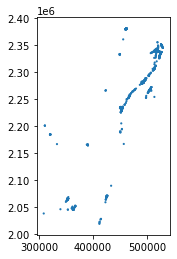

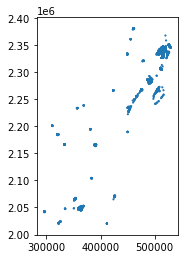

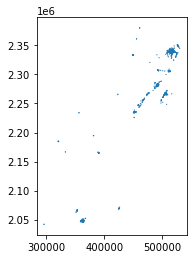

In [94]:
denue_lodging_buffer_gdf.plot()
denue_foodbev_buffer_gdf.plot()
denue_entrec_buffer_gdf.plot()

In [95]:
# Combine all the DENUE buffers into a single GDF
denue_buffered = pd.concat([denue_lodging_buffer_gdf, denue_foodbev_buffer_gdf, denue_entrec_buffer_gdf], axis=0, ignore_index=True)
denue_buffered

,d_llave,nom_est,cve_scian,desc_scian,sector,geometry,dnu_type,dnu_lodg,dnu_fdbev,dnu_entrec
0,6384383,HOTEL COLONIAL SAN CARLOS,721112,Hoteles sin otros servicios integrados,72,"POLYGON ((519942.818 2340740.074, 519942.818 2...",lodging,1.0,NaN,NaN
1,6384240,HOSPEDAJE MARIA LETICIA,721311,Pensiones y casas de huéspedes,72,"POLYGON ((528046.342 2350714.577, 528046.342 2...",lodging,1.0,NaN,NaN
2,3642060,VILLAS DEJA BLUE,721312,Departamentos y casas amueblados con servicios...,72,"POLYGON ((506325.185 2266856.555, 506325.185 2...",lodging,1.0,NaN,NaN
3,6383956,HOTEL PEPITA,721112,Hoteles sin otros servicios integrados,72,"POLYGON ((507396.483 2267763.846, 507396.483 2...",lodging,1.0,NaN,NaN
4,6484081,POSADA LAMAR,721311,Pensiones y casas de huéspedes,72,"POLYGON ((454616.194 2229786.188, 454616.194 2...",lodging,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
12303,8618054,CENTRO DE ACONDICIONAMIENTO FISICO DEL SECTOR ...,713943,Centros de acondicionamiento físico del sector...,71,"POLYGON ((365945.917 2049350.528, 365941.102 2...",ent_rec,NaN,NaN,1.0
12304,8193446,LA BOLITA PRONOSTICO,713291,"Venta de billetes de lotería, pronósticos depo...",71,"POLYGON ((508106.892 2267293.302, 508102.077 2...",ent_rec,NaN,NaN,1.0
12305,7833593,CENTRO DE ENTRENAMIENTO GENOMA,713943,Centros de acondicionamiento físico del sector...,71,"POLYGON ((493206.668 2283881.479, 493201.853 2...",ent_rec,NaN,NaN,1.0
12306,3658171,LOTERIA NACIONAL,713291,"Venta de billetes de lotería, pronósticos depo...",71,"POLYGON ((514185.518 2341473.099, 514180.702 2...",ent_rec,NaN,NaN,1.0


In [96]:
# Spatially Join the DENUE lodging/food/entertainment buffers to Shore segment points
denue_shorepts_join = gpd.sjoin(shore_points_gdf, denue_buffered, op='intersects')
denue_shorepts_join

,shore_desc,desc_abbrev,distance,shore_ptid,type_geomorph,seg_id,nearest_x,nearest_y,geometry,index_right,d_llave,nom_est,cve_scian,desc_scian,sector,dnu_type,dnu_lodg,dnu_fdbev,dnu_entrec
0,Isla Mujeres,imu,10.0,imu_000010,sand,190,2.351487e+06,526079.020764,POINT (526079.021 2351487.282),1,6384240,HOSPEDAJE MARIA LETICIA,721311,Pensiones y casas de huéspedes,72,lodging,1.0,NaN,NaN
1,Isla Mujeres,imu,60.0,imu_000060,sand,190,2.351521e+06,526069.071721,POINT (526069.072 2351520.957),1,6384240,HOSPEDAJE MARIA LETICIA,721311,Pensiones y casas de huéspedes,72,lodging,1.0,NaN,NaN
2,Isla Mujeres,imu,110.0,imu_000110,sand,190,2.351481e+06,526050.024372,POINT (526050.024 2351480.878),1,6384240,HOSPEDAJE MARIA LETICIA,721311,Pensiones y casas de huéspedes,72,lodging,1.0,NaN,NaN
3,Isla Mujeres,imu,160.0,imu_000160,sand,190,2.351494e+06,526015.595971,POINT (526015.596 2351494.100),1,6384240,HOSPEDAJE MARIA LETICIA,721311,Pensiones y casas de huéspedes,72,lodging,1.0,NaN,NaN
4,Isla Mujeres,imu,210.0,imu_000210,sand,190,2.351456e+06,526010.366221,POINT (526010.366 2351455.699),1,6384240,HOSPEDAJE MARIA LETICIA,721311,Pensiones y casas de huéspedes,72,lodging,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25900,Cozumel,coz,123260.0,coz_123260,sand,107,2.272786e+06,508226.627512,POINT (508226.628 2272785.628),12015,6493528,COZUMEL COUNTRY CLUB,713910,Campos de golf,71,ent_rec,NaN,NaN,1.0
25901,Cozumel,coz,123310.0,coz_123310,sand,107,2.272793e+06,508276.042389,POINT (508276.042 2272793.229),12015,6493528,COZUMEL COUNTRY CLUB,713910,Campos de golf,71,ent_rec,NaN,NaN,1.0
25902,Cozumel,coz,123360.0,coz_123360,sand,107,2.272806e+06,508324.314865,POINT (508324.315 2272805.708),12015,6493528,COZUMEL COUNTRY CLUB,713910,Campos de golf,71,ent_rec,NaN,NaN,1.0
25903,Cozumel,coz,123410.0,coz_123410,sand,107,2.272821e+06,508371.641311,POINT (508371.641 2272821.195),12015,6493528,COZUMEL COUNTRY CLUB,713910,Campos de golf,71,ent_rec,NaN,NaN,1.0


In [115]:
# Group by different DENUE types
# All types together
# denue_count_seg_df = denue_shorepts_join.groupby(['seg_id','dnu_type'])['d_llave'].nunique().reset_index()
# denue_lodging_count_seg_df.rename(columns={'d_llave': 'dnu_cnt'}, inplace=True)
# denue_count_seg_df
# Individual types
# Lodging
denue_lodging_count_seg_df = denue_shorepts_join[(denue_shorepts_join['dnu_type'] == 'lodging')].groupby(
    ['seg_id'])['d_llave'].nunique().reset_index()
denue_lodging_count_seg_df.rename(columns={'d_llave': 'lodge_cnt'}, inplace=True)
print(denue_lodging_count_seg_df.head())
# Food & Beverage
denue_foodbev_count_seg_df = denue_shorepts_join[(denue_shorepts_join['dnu_type'] == 'food_bev')].groupby(
    ['seg_id'])['d_llave'].nunique().reset_index()
denue_foodbev_count_seg_df.rename(columns={'d_llave': 'fdbev_cnt'}, inplace=True)
print(denue_foodbev_count_seg_df.head())
# Entertainment and Recreation
denue_entrec_count_seg_df = denue_shorepts_join[(denue_shorepts_join['dnu_type'] == 'ent_rec')].groupby(
    ['seg_id'])['d_llave'].nunique().reset_index()
denue_entrec_count_seg_df.rename(columns={'d_llave': 'entrec_cnt'}, inplace=True)
print(denue_entrec_count_seg_df.head())

   seg_id  lodge_cnt
0       1          8
1       4          1
2       7         17
3      12          9
4      15          3
   seg_id  fdbev_cnt
0       1         79
1       7        144
2      12         21
3      14          4
4      15         12
   seg_id  entrec_cnt
0       1           2
1      12          14
2      15           1
3      16           1
4      17           1


In [116]:
# shore_segments_atts_gdf = shore_segments_gdf.join([hotel_count_seg_df, denue_lodging_count_seg_df, denue_foodbev_count_seg_df, denue_entrec_count_seg_df], on='seg_id')
# join only works on indexes, not arbitrary columns
joined1 = pd.merge(shore_segments_gdf, hotel_count_seg_df, on='seg_id', how='left')
joined2 = pd.merge(joined1, denue_lodging_count_seg_df, on='seg_id', how='left')
joined3 = pd.merge(joined2, denue_foodbev_count_seg_df, on='seg_id', how='left')
shore_segments_atts_gdf = pd.merge(joined3, denue_entrec_count_seg_df, on='seg_id', how='left')
shore_segments_atts_gdf

,type_geomorph,length_km,seg_id,shore_desc,desc_abbrev,geometry,hotel_cnt,lodge_cnt,fdbev_cnt,entrec_cnt
0,cliff or rocky,2.188708,1,Isla Mujeres,imu,"MULTILINESTRING ((530027.596 2344472.852, 5300...",8.0,8.0,79.0,2.0
1,sand,3.738697,2,Isla Contoy,ico,"MULTILINESTRING ((521010.617 2378995.910, 5210...",NaN,NaN,NaN,NaN
2,mixed mud and sand,5.758523,3,QR mainland,qrm,"MULTILINESTRING ((439281.990 2130747.294, 4392...",NaN,NaN,NaN,NaN
3,sand,5.622333,4,QR mainland,qrm,"MULTILINESTRING ((433485.994 2090201.431, 4334...",1.0,1.0,NaN,NaN
4,sand,2.136723,5,QR mainland,qrm,"MULTILINESTRING ((410987.143 2013924.228, 4109...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
192,cliff or rocky,5.019248,193,QR mainland,qrm,"MULTILINESTRING ((444590.092 2376499.228, 4447...",NaN,NaN,NaN,NaN
193,sand,8.177061,194,Holbox,hol,"MULTILINESTRING ((488231.217 2388467.313, 4882...",NaN,NaN,NaN,NaN
194,sand,11.078166,195,QR mainland,qrm,"MULTILINESTRING ((516830.778 2314283.226, 5168...",32.0,24.0,59.0,9.0
195,sand,0.784313,196,Isla de la Pasion,ipa,"MULTILINESTRING ((513991.173 2272135.231, 5139...",NaN,NaN,1.0,NaN


In [118]:
shore_segments_atts_gdf.fillna(0, inplace=True)
shore_segments_atts_gdf

,type_geomorph,length_km,seg_id,shore_desc,desc_abbrev,geometry,hotel_cnt,lodge_cnt,fdbev_cnt,entrec_cnt
0,cliff or rocky,2.188708,1,Isla Mujeres,imu,"MULTILINESTRING ((530027.596 2344472.852, 5300...",8.0,8.0,79.0,2.0
1,sand,3.738697,2,Isla Contoy,ico,"MULTILINESTRING ((521010.617 2378995.910, 5210...",0.0,0.0,0.0,0.0
2,mixed mud and sand,5.758523,3,QR mainland,qrm,"MULTILINESTRING ((439281.990 2130747.294, 4392...",0.0,0.0,0.0,0.0
3,sand,5.622333,4,QR mainland,qrm,"MULTILINESTRING ((433485.994 2090201.431, 4334...",1.0,1.0,0.0,0.0
4,sand,2.136723,5,QR mainland,qrm,"MULTILINESTRING ((410987.143 2013924.228, 4109...",0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
192,cliff or rocky,5.019248,193,QR mainland,qrm,"MULTILINESTRING ((444590.092 2376499.228, 4447...",0.0,0.0,0.0,0.0
193,sand,8.177061,194,Holbox,hol,"MULTILINESTRING ((488231.217 2388467.313, 4882...",0.0,0.0,0.0,0.0
194,sand,11.078166,195,QR mainland,qrm,"MULTILINESTRING ((516830.778 2314283.226, 5168...",32.0,24.0,59.0,9.0
195,sand,0.784313,196,Isla de la Pasion,ipa,"MULTILINESTRING ((513991.173 2272135.231, 5139...",0.0,0.0,1.0,0.0


In [119]:
# Export segments with Lodging, Food/Bev, Entertainment/Recreation to Geopackage
shore_segments_atts_gdf.to_file(shore_gpkg, layer='shoreQR_segments_lodg_food_ent', driver="GPKG")